In [1]:
from datasets import load_dataset
from huggingface_hub import login
import tiktoken
import pandas as pd
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

In [ ]:
def evaluate_and_characterize_failures(trajectory, target, nums, tokenizer=AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct")) -> dict:
    """
    Evaluates a countdown task trajectory and returns detailed diagnosis information
    for all error types, plus equation statistics.
    
    Args:
        trajectory (str): The reasoning trajectory text
        target (int/float): The target number to reach
        nums (list): List of starting numbers available
    
    Returns:
        dict: Results containing various error indicators and statistics
    """
    import re
    import ast
    import math
    from typing import List

    # Initialize error flags
    is_valid = True
    arithmetic_error = False
    sign_error = False
    invalid_number_usage = False
    formatting_issues = False
    token_count = len(tokenizer(trajectory)["input_ids"])
    
    # Initialize equation counters
    total_equations = 0
    arithmetic_error_count = 0
    sign_error_count = 0
    
    # Initialize heuristic calculation tracking
    heuristic_calculation_count = 0
    heuristic_arithmetic_errors = 0
    
    # Initialize node tracking
    nodes = {}
    node_recall_errors = 0
    
    # Enhanced pattern to capture both "=" and "is" as equation separators with flexible spacing
    equation_pattern = re.compile(r"([\d.]+)\s*([\+\-\*/])\s*([\d.]+)\s*(?:=|is)\s*([\d.]+)")
    all_equations = equation_pattern.findall(trajectory)
    
    total_equations = len(all_equations)
    
    # Check each equation for arithmetic correctness and sign errors
    for eq in all_equations:
        try:
            num1 = float(eq[0])
            op = eq[1]
            num2 = float(eq[2])
            result = float(eq[3])
            
            # Calculate the expected result
            if op == '+':
                expected = num1 + num2
            elif op == '-':
                expected = num1 - num2
            elif op == '*':
                expected = num1 * num2
            elif op == '/':
                if math.isclose(num2, 0.0):
                    arithmetic_error_count += 1
                    continue
                expected = num1 / num2
            else:
                # Invalid operator
                continue
                
            # Compare expected vs. given result
            if not math.isclose(expected, result, rel_tol=1e-5):
                arithmetic_error_count += 1
                
                # Check for sign error (same absolute value but wrong sign)
                if math.isclose(abs(expected), abs(result), rel_tol=1e-5) and math.copysign(1, expected) != math.copysign(1, result):
                    sign_error_count += 1
                
        except Exception:
            # Skip equations with parsing issues
            continue
    
    # Track node definitions
    node_pattern = re.compile(r"Node (\d+):\s*nums=\[([\d, ]+)\]")
    for match in node_pattern.finditer(trajectory):
        node_id = match.group(1)
        nums_str = match.group(2)
        try:
            nums_list = [int(n.strip()) for n in nums_str.split(",") if n.strip()]
            
            # Check if node was already seen and numbers differ
            if node_id in nodes:
                if set(nums_list) != set(nodes[node_id]):
                    node_recall_errors += 1
            else:
                nodes[node_id] = nums_list
        except:
            pass  # Skip if there's an issue parsing the numbers
    
    # Find and validate heuristic score calculations
    # Pattern for simple heuristic count
    heuristic_pattern = re.compile(r"Heuristic score\s*:", re.IGNORECASE)
    heuristic_lines = [m.start() for m in re.finditer(heuristic_pattern, trajectory)]
    heuristic_calculation_count = len(heuristic_lines)
    
    # Detailed pattern for validating the arithmetic in heuristic calculations
    # This is complex and may need tuning based on actual format
    heuristic_calc_pattern = re.compile(
        r"Heuristic score\s*:\s*\((.*?)\)/(\d+)\s*=\s*(.*?)\s*=\s*([\d.]+)", 
        re.IGNORECASE
    )
    
    for match in heuristic_calc_pattern.finditer(trajectory):
        # Extract the parts of the calculation
        expressions_part = match.group(1)  # e.g. "|9-20| + |67-20| + |57-20|"
        divisor = int(match.group(2))      # e.g. 3
        sums_part = match.group(3)         # e.g. "(11 + 47 + 37)"
        try:
            float_num = match.group(4)
            if float_num.endswith("..."):
                float_num = float_num[:-3]
            claimed_result = float(float_num)  # e.g. 30.33
        except Exception as e:
            print("Not just elipses issue, parsing as None: ", e)
            # if elipses issue
            claimed_result = None    
        # Find individual absolute values in the expression
        abs_values = []
        try:
            # Extract values from sums part (e.g. "11 + 47 + 37")
            terms = re.findall(r'(\d+(?:\.\d+)?)', sums_part)
            abs_values = [float(t) for t in terms]
            
            # Calculate expected result
            expected_sum = sum(abs_values)
            expected_result = expected_sum / divisor
            
            # Compare with claimed result
            if not math.isclose(expected_result, claimed_result, rel_tol=1e-2):
                heuristic_arithmetic_errors += 1
        except:
            # If we can't fully parse the heuristic calculation, just count it
            pass
    
    # Check for incomplete trajectory
    if not re.search(r"RESULT:", trajectory):
        incomplete_trajectory = True
        is_valid = False
    
    # Check for formatting: SOLUTION field
    sol_match = re.search(r"SOLUTION:\s*(YES|NO)", trajectory, re.IGNORECASE)
    if not sol_match:
        formatting_issues = True
        is_valid = False
    else:
        sol_decl = sol_match.group(1).upper()
        if sol_decl != "YES":
            is_valid = False
    
    # Extract OPERATIONS list
    operations = []
    ops_match = re.search(r"OPERATIONS:\s*(\[[^\]]*\])", trajectory, re.DOTALL)
    if not ops_match:
        formatting_issues = True
        is_valid = False
    else:
        try:
            operations = ast.literal_eval(ops_match.group(1))
            if not isinstance(operations, list):
                formatting_issues = True
                is_valid = False
        except Exception:
            formatting_issues = True
            is_valid = False
    
    # Extract final RESULT
    expected_final = None
    res_match = re.search(r"RESULT:\s*([-+.\d]+)", trajectory)
    if not res_match:
        formatting_issues = True
        is_valid = False
    else:
        try:
            expected_final = float(res_match.group(1))
        except Exception:
            formatting_issues = True
            is_valid = False
    
    # If we have severe formatting issues, we can't proceed with arithmetic and usage checks
    if formatting_issues or not operations:
        return {
            "is_valid": is_valid,
            "arithmetic_error": arithmetic_error,
            "sign_error": sign_error,
            "invalid_number_usage": invalid_number_usage,
            "formatting_issues": formatting_issues,
            "total_equations": total_equations,
            "arithmetic_error_count": arithmetic_error_count,
            "token_count": token_count,
            "sign_error_count": sign_error_count,
            "heuristic_calculation_count": heuristic_calculation_count,
            "heuristic_arithmetic_errors": heuristic_arithmetic_errors,
            "node_recall_errors": node_recall_errors
        }
    
    # Simulation: available numbers (as floats)
    available = [float(n) for n in nums]
    
    # Enhanced operation pattern for validation
    op_pattern = re.compile(r"^\s*([\d.]+)\s*([\+\-\*/])\s*([\d.]+)\s*(?:=|is)\s*([\d.]+)\s*$")
    
    operation_results = []  # Store results to check if all numbers were used
    
    for op_str in operations:
        m = op_pattern.match(op_str)
        if not m:
            formatting_issues = True
            is_valid = False
            continue
        
        op1_str, operator, op2_str, given_result_str = m.groups()
        try:
            op1 = float(op1_str)
            op2 = float(op2_str)
            op_result = float(given_result_str)
        except Exception:
            formatting_issues = True
            is_valid = False
            continue
        
        # Check arithmetic correctness
        try:
            if operator == '+':
                computed = op1 + op2
            elif operator == '-':
                computed = op1 - op2
            elif operator == '*':
                computed = op1 * op2
            elif operator == '/':
                if math.isclose(op2, 0.0):
                    arithmetic_error = True
                    is_valid = False
                    continue
                computed = op1 / op2
            else:
                formatting_issues = True
                is_valid = False
                continue
                
            if not math.isclose(computed, op_result, rel_tol=1e-5):
                arithmetic_error = True
                is_valid = False
                
                # Check for sign error (same absolute value but wrong sign)
                if math.isclose(abs(computed), abs(op_result), rel_tol=1e-5):
                    sign_error_count += 1
                    sign_error = True
        except Exception:
            arithmetic_error = True
            is_valid = False
            continue
        
        operation_results.append((op1, op2, op_result))
    
    # Check for invalid number usage by simulating all operations
    if operation_results:
        try:
            # Reset available numbers for a fresh check
            available = [float(n) for n in nums]
            
            def consume(value, pool):
                for i, num in enumerate(pool):
                    if math.isclose(num, value, rel_tol=1e-5):
                        del pool[i]
                        return True
                return False
            
            for op1, op2, result in operation_results:
                if not consume(op1, available):
                    invalid_number_usage = True
                    is_valid = False
                    break
                
                if not consume(op2, available):
                    invalid_number_usage = True
                    is_valid = False
                    break
                
                available.append(result)
            
            # After all operations, should have exactly one number equal to target
            if len(available) != 1:
                invalid_number_usage = True
                is_valid = False
            elif expected_final is not None and not math.isclose(available[0], float(target), rel_tol=1e-5):
                arithmetic_error = True
                is_valid = False
                
        except Exception:
            invalid_number_usage = True
            is_valid = False
    
    return {
        "is_valid": is_valid,
        "arithmetic_error": arithmetic_error,
        "sign_error": sign_error,
        "invalid_number_usage": invalid_number_usage, 
        "formatting_issues": formatting_issues,
        "total_equations": total_equations,
        "arithmetic_error_count": arithmetic_error_count,
        "token_count": token_count,
        "sign_error_count": sign_error_count,
        "heuristic_calculation_count": heuristic_calculation_count,
        "heuristic_arithmetic_errors": heuristic_arithmetic_errors,
        "node_recall_errors": node_recall_errors
    }

In [ ]:
from glob import glob
import os 
import json 
import re 

def parse_model_filepath(filepath):
    """
    Parse a model filepath to extract model size, dataset type, context length, and dataset size.
    
    Args:
        filepath (str): Path to the model file
        
    Returns:
        dict: Dictionary containing model_size, dataset_type, context_length, and dataset_size
    """
    # Extract the directory part of the path
    directory = os.path.dirname(filepath)
    # Get the last part of the directory path (the model folder name)
    model_folder = os.path.basename(directory)
    
    # Initialize result dictionary
    result = {
        "model_size": None,
        "dataset_type": None,
        "context_length": None,
        "dataset_size": None
    }
    
    # Extract model size (e.g., 0.5B, 1.5B)
    model_size_match = re.search(r'(\d+\.\d+B)', model_folder)
    if model_size_match:
        result["model_size"] = model_size_match.group(1)
    
    # Extract dataset type (e.g., o3, search, search-react)
    # We need to handle special cases like "search-react" and "search-long"
    if "search-react" in model_folder:
        result["dataset_type"] = "search-react"
    elif "search-long" in model_folder:
        result["dataset_type"] = "search-long"
    elif "search" in model_folder:
        result["dataset_type"] = "search"
    elif "optimal" in model_folder:
        result["dataset_type"] = "optimal"
    elif "o3" in model_folder:
        result["dataset_type"] = "o3"
    
    # Extract context length (e.g., 8k from seq8k)
    context_match = re.search(r'seq(\d+k)', model_folder)
    if context_match:
        result["context_length"] = context_match.group(1)
    else:
        result["context_length"] = "4k"  # Default to 4k if not found
    
    # Extract dataset size (e.g., 1k, 5k)
    # This is typically the last part of the model folder name
    dataset_size_match = re.search(r'(\d+k)(?:/|$)', model_folder)
    if dataset_size_match:
        result["dataset_size"] = dataset_size_match.group(1)
    
    return result

def find_experiment_files(base_dir, pattern="**/test_128*.json"):
    """Find all experiment result files in the given directory."""
    return glob(os.path.join(base_dir, pattern), recursive=True)

def process_trajectories_to_dataframe(file_path):
    """
    Process a single results file and convert trajectories to a pandas DataFrame
    with metadata and evaluation results.
    
    Args:
        file_path (str): Path to the JSON file
        
    Returns:
        pd.DataFrame: DataFrame with trajectories and their evaluations
    """
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        # Skip the first two elements as per requirements
        if len(data) <= 2:
            print(f"Warning: {os.path.basename(file_path)} has fewer than 3 elements. Skipping.")
            return pd.DataFrame()
            
        trajectories = data[2:]  # Start from the 3rd element
        
        # Get model metadata
        model_info = parse_model_filepath(file_path)
        
        # Process each trajectory
        trajectories_results = []
        for idx, row in enumerate(trajectories):
            result = evaluate_and_characterize_failures(
                row["completion"], 
                row["target"], 
                row["nums"]
            )
            
            # Add trajectory data and model metadata
            result["trajectory_index"] = idx
            result["completion"] = row["completion"]
            result["target"] = row["target"]
            result["nums"] = row["nums"]
            result["file_path"] = file_path
            
            # Add model metadata
            for key, value in model_info.items():
                result[key] = value
                
            trajectories_results.append(result)
        
        return pd.DataFrame(trajectories_results)
        
    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {str(e)}")
        return pd.DataFrame()


def process_json_files(base_dir):
    """
    Find and process all experiment result files, returning both individual trajectories
    and aggregate statistics.
    
    Args:
        base_dir (str): Base directory to search for experiment files
        
    Returns:
        tuple: (trajectory_df, stats_df) where:
            - trajectory_df: DataFrame with each trajectory and its evaluation
            - stats_df: DataFrame with aggregate statistics for each model
    """
    # Find all test_*.json files
    test_files = find_experiment_files(base_dir)
    
    # Process each file to get individual trajectories
    all_trajectories = []
    for file_path in tqdm(test_files):
        df = process_trajectories_to_dataframe(file_path)
        all_trajectories.append(df)
    
    # Combine all trajectories
    if all_trajectories:
        trajectory_df = pd.concat(all_trajectories, ignore_index=True)
    else:
        trajectory_df = pd.DataFrame()
    
    # Calculate aggregate statistics per file/model
    stats_results = []
    # Group by file path to calculate stats
    if not trajectory_df.empty:
        for file_path, file_df in trajectory_df.groupby("file_path"):
            # Get model info once (same for all rows in this group)
            model_info = {
                "model_size": file_df["model_size"].iloc[0],
                "dataset_type": file_df["dataset_type"].iloc[0],
                "context_length": file_df["context_length"].iloc[0],
                "dataset_size": file_df["dataset_size"].iloc[0]
            }
            
            # Calculate statistics
            total_rows = len(file_df)
            max_tokens = file_df["token_count"].max()
            
            # Get counts of various issues
            total_is_valid = file_df["is_valid"].sum()
            total_has_arithmetic_error = file_df["arithmetic_error"].sum()
            total_has_sign_error = file_df["sign_error"].sum()
            total_has_invalid_number = file_df["invalid_number_usage"].sum()
            total_has_formatting_issues = file_df["formatting_issues"].sum()

            # Calculate incomplete trajectories
            max_token_count_occurrences = (file_df["token_count"] == max_tokens).sum()
            total_has_formatting_issues_and_reach_max_tokens = 0

            if max_token_count_occurrences >= 2:
                # Only count incomplete trajectories if we have at least 2 trajectories with max token count
                total_has_formatting_issues_and_reach_max_tokens = ((file_df["formatting_issues"]) & 
                                                            np.isclose(file_df["token_count"],max_tokens, 1e-2)).sum()
                total_has_formatting_issues = ((file_df["formatting_issues"]) & 
                                                    (np.isclose(file_df["token_count"],max_tokens, 1e-2)==False)).sum()

            # Calculate percentage of arithmetic errors per trajectory
            arithmetic_error_percentages = []
            for _, row in file_df.iterrows():
                if row["total_equations"] > 0:
                    error_percentage = row["arithmetic_error_count"] / row["total_equations"]
                    arithmetic_error_percentages.append(error_percentage)
                else:
                    arithmetic_error_percentages.append(0.0)

            # Calculate mean percentage of arithmetic errors
            mean_percentage_arithmetic_error = 0
            if arithmetic_error_percentages:
                mean_percentage_arithmetic_error = sum(arithmetic_error_percentages) / len(arithmetic_error_percentages)
            
            # Create statistics dictionary
            stats = model_info.copy()
            stats.update({
                "total_rows": total_rows,
                "perc_success": total_is_valid/total_rows,
                "perc_failed_by_arithmetic_errors_in_answer": total_has_arithmetic_error/total_rows,
                "perc_failed_by_sign_errors_in_answer": total_has_sign_error/total_rows,
                "perc_failed_by_using_invalid_numbers": total_has_invalid_number/total_rows,
                "perc_failed_by_incomplete_trajectories": total_has_formatting_issues_and_reach_max_tokens/total_rows,
                "perc_failed_by_formatting_issues": total_has_formatting_issues/total_rows,
                "mean_perc_arithmetic_errors_in_full_trajectory": mean_percentage_arithmetic_error,
                "max_token_count_occurrences": max_token_count_occurrences/total_rows,
                "max_tokens": max_tokens
            })
            stats_results.append(stats)
    
    # Create DataFrame from aggregated results
    stats_df = pd.DataFrame(stats_results)
    
    return trajectory_df, stats_df

In [14]:
trajectory_df, stats_df = process_json_files("./")

  0%|          | 0/37 [00:00<?, ?it/s]

 92%|█████████▏| 34/37 [02:04<00:06,  2.14s/it]

Error processing test_128_20250404-180326.json: expected string or bytes-like object


100%|██████████| 37/37 [02:09<00:00,  3.49s/it]


Error processing test_128_20250406-032204.json: Expecting value: line 1 column 1 (char 0)


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

def visualize_metrics(
    stats_df,
    model_sizes=['1.5B'],
    dataset_types=['search-react'],
    dataset_sizes=['1k', '5k'],
    context_lengths=['8k', '10k'],
    metric_cols=None,
    save_path="images/",
    show_figure=True,
    figsize=(15, 20)
):
    """
    Visualize selected metrics across different configurations and save individual plots.
    
    Parameters:
    -----------
    stats_df : pandas.DataFrame
        DataFrame containing the metrics data
    model_sizes : list, optional
        List of model sizes to include (e.g., ['1.5B', '7B'])
    dataset_types : list, optional
        List of dataset types to include (e.g., ['search-react', 'search'])
    dataset_sizes : list, optional
        List of dataset sizes to include (e.g., ['1k', '5k'])
    context_lengths : list, optional
        List of context lengths to include (e.g., ['8k', '10k'])
    metric_cols : list, optional
        List of metric columns to visualize
    save_path : str, optional
        Directory to save individual metric plots
    show_figure : bool, optional
        Whether to display the figure in the notebook
    figsize : tuple, optional
        Size of the figure (width, height)
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object containing all the plots
    """
    # Create save directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # Filter the dataframe based on provided parameters
    df_filtered = stats_df[
        (stats_df['model_size'].isin(model_sizes)) & 
        (stats_df['dataset_size'].isin(dataset_sizes)) & 
        (stats_df['dataset_type'].isin(dataset_types)) & 
        (stats_df['context_length'].isin(context_lengths))
    ]
    
    # Use default metric columns if none provided
    if metric_cols is None:
        metric_cols = [
            'perc_success',
            'perc_failed_by_arithmetic_errors_in_answer',
            'perc_failed_by_sign_errors_in_answer',
            'perc_failed_by_using_invalid_numbers',
            'perc_failed_by_incomplete_trajectories',
            'perc_failed_by_formatting_issues',
            'mean_perc_arithmetic_errors_in_full_trajectory',
        ]
    
    # Custom color palette: assign base colors to dataset_types
    base_palette = sns.color_palette("Set2", n_colors=len(dataset_types))
    color_mapping = {dtype: base_palette[i] for i, dtype in enumerate(dataset_types)}
    
    # Alpha mapping for dataset sizes
    alpha_mapping = {size: (0.4 + 0.6 * i / (len(dataset_sizes) - 1)) for i, size in enumerate(dataset_sizes)} if len(dataset_sizes) > 1 else {dataset_sizes[0]: 1.0}
    
    # Plot
    n_metrics = len(metric_cols)
    n_cols = 2
    n_rows = (n_metrics + 1) // n_cols
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, constrained_layout=True)
    
    # Make axs always 2D even for a single row or column
    if n_metrics == 1:
        axs = np.array([[axs]])
    elif n_rows == 1:
        axs = axs.reshape(1, -1)
    elif n_cols == 1:
        axs = axs.reshape(-1, 1)
    
    for i, metric in enumerate(metric_cols):
        ax = axs[i // n_cols, i % n_cols]
        bar_positions = []
        bar_labels = []
        bar_heights = []
        bar_colors = []
        bar_alphas = []
        
        # Collect data for bars
        for model_size in model_sizes:
            for dtype in dataset_types:
                for size in dataset_sizes:
                    for context_length in context_lengths:
                        subset = df_filtered[
                            (df_filtered['model_size'] == model_size) &
                            (df_filtered['dataset_type'] == dtype) & 
                            (df_filtered['dataset_size'] == size) &
                            (df_filtered['context_length'] == context_length)
                        ]
                        
                        if not subset.empty:
                            # Create label with all dimensions if multiple values exist in any dimension
                            if len(model_sizes) > 1:
                                label = f"{dtype}-{size}-{context_length}-{model_size}"
                            else:
                                label = f"{dtype}-{size}-{context_length}"
                                
                            value = subset[metric].values[0]
                            
                            bar_positions.append(len(bar_positions))
                            bar_labels.append(label)
                            bar_heights.append(value)
                            bar_colors.append(color_mapping[dtype])
                            bar_alphas.append(alpha_mapping[size])
        
        # Plot bars individually with their respective alpha values
        bars = []
        for pos, height, color, alpha_val in zip(bar_positions, bar_heights, bar_colors, bar_alphas):
            bar = ax.bar(
                pos,
                height,
                color=color,
                alpha=alpha_val,
                width=0.8
            )
            bars.append(bar[0])  # bar() returns a container with one rectangle
        
        # Add value annotations
        for bar, height in zip(bars, bar_heights):
            ax.text(
                bar.get_x() + bar.get_width()/2,
                height + 0.02,
                f"{height:.2f}",
                ha='center',
                va='bottom',
                fontsize=9
            )
        
        # Set x-axis labels
        ax.set_xticks(bar_positions)
        ax.set_xticklabels(bar_labels, rotation=45, ha='right')
        
        # Set y-axis range
        if "perc" in metric:
            ax.set_ylim(0, 1)
        
        # Format title
        title = metric.title().replace("_", " ").replace("Perc", "%")
        ax.set_title(title)
        ax.set_ylabel("Value")
        
        # Add a legend for dataset types
        handles = []
        labels = []
        for dtype in dataset_types:
            handles.append(plt.Rectangle((0,0), 1, 1, color=color_mapping[dtype]))
            labels.append(dtype)
            
        # Add a legend for dataset sizes if there's more than one
        if len(dataset_sizes) > 1:
            for size in dataset_sizes:
                handles.append(plt.Rectangle((0,0), 1, 1, color='gray', alpha=alpha_mapping[size]))
                labels.append(f"Size: {size}")
                
        ax.legend(handles, labels, loc='upper right')
        
        # Save individual metric plot
        plt.figure(figsize=(8, 6))
        # Plot bars individually for the single metric plot
        for pos, height, color, alpha_val in zip(bar_positions, bar_heights, bar_colors, bar_alphas):
            plt.bar(
                pos,
                height,
                color=color,
                alpha=alpha_val,
                width=0.8
            )
        plt.xticks(bar_positions, bar_labels, rotation=45, ha='right')
        plt.title(title)
        plt.ylabel("Value")
        if "perc" in metric:
            plt.ylim(0, 1)
        plt.tight_layout()
        
        # Create filename
        filename = f"{metric}_{'_'.join(model_sizes)}_{'_'.join(dataset_types)}.png"
        plt.savefig(os.path.join(save_path, filename))
        plt.close()  # Close the individual figure
    
    # Handle empty subplot if odd number of metrics
    if n_metrics % 2 == 1 and n_cols > 1:
        axs[n_rows-1, n_cols-1].axis('off')
    
    plt.tight_layout()
    
    # Save the complete figure
    fig.savefig(os.path.join(save_path, "all_metrics.png"), bbox_inches='tight')
    
    if show_figure:
        plt.show()
    
    return fig

In [6]:
# Comparing multiple dataset types for dataset size=5k and context length=8k
fig = visualize_metrics(
    stats_df,
    dataset_types=['optimal', 'search-react', 'search'], 
    dataset_sizes=['5k'],
    context_lengths=['8k']
)
fig.show()

KeyError: 'model_size'

/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_20728/1179833262.py:206: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


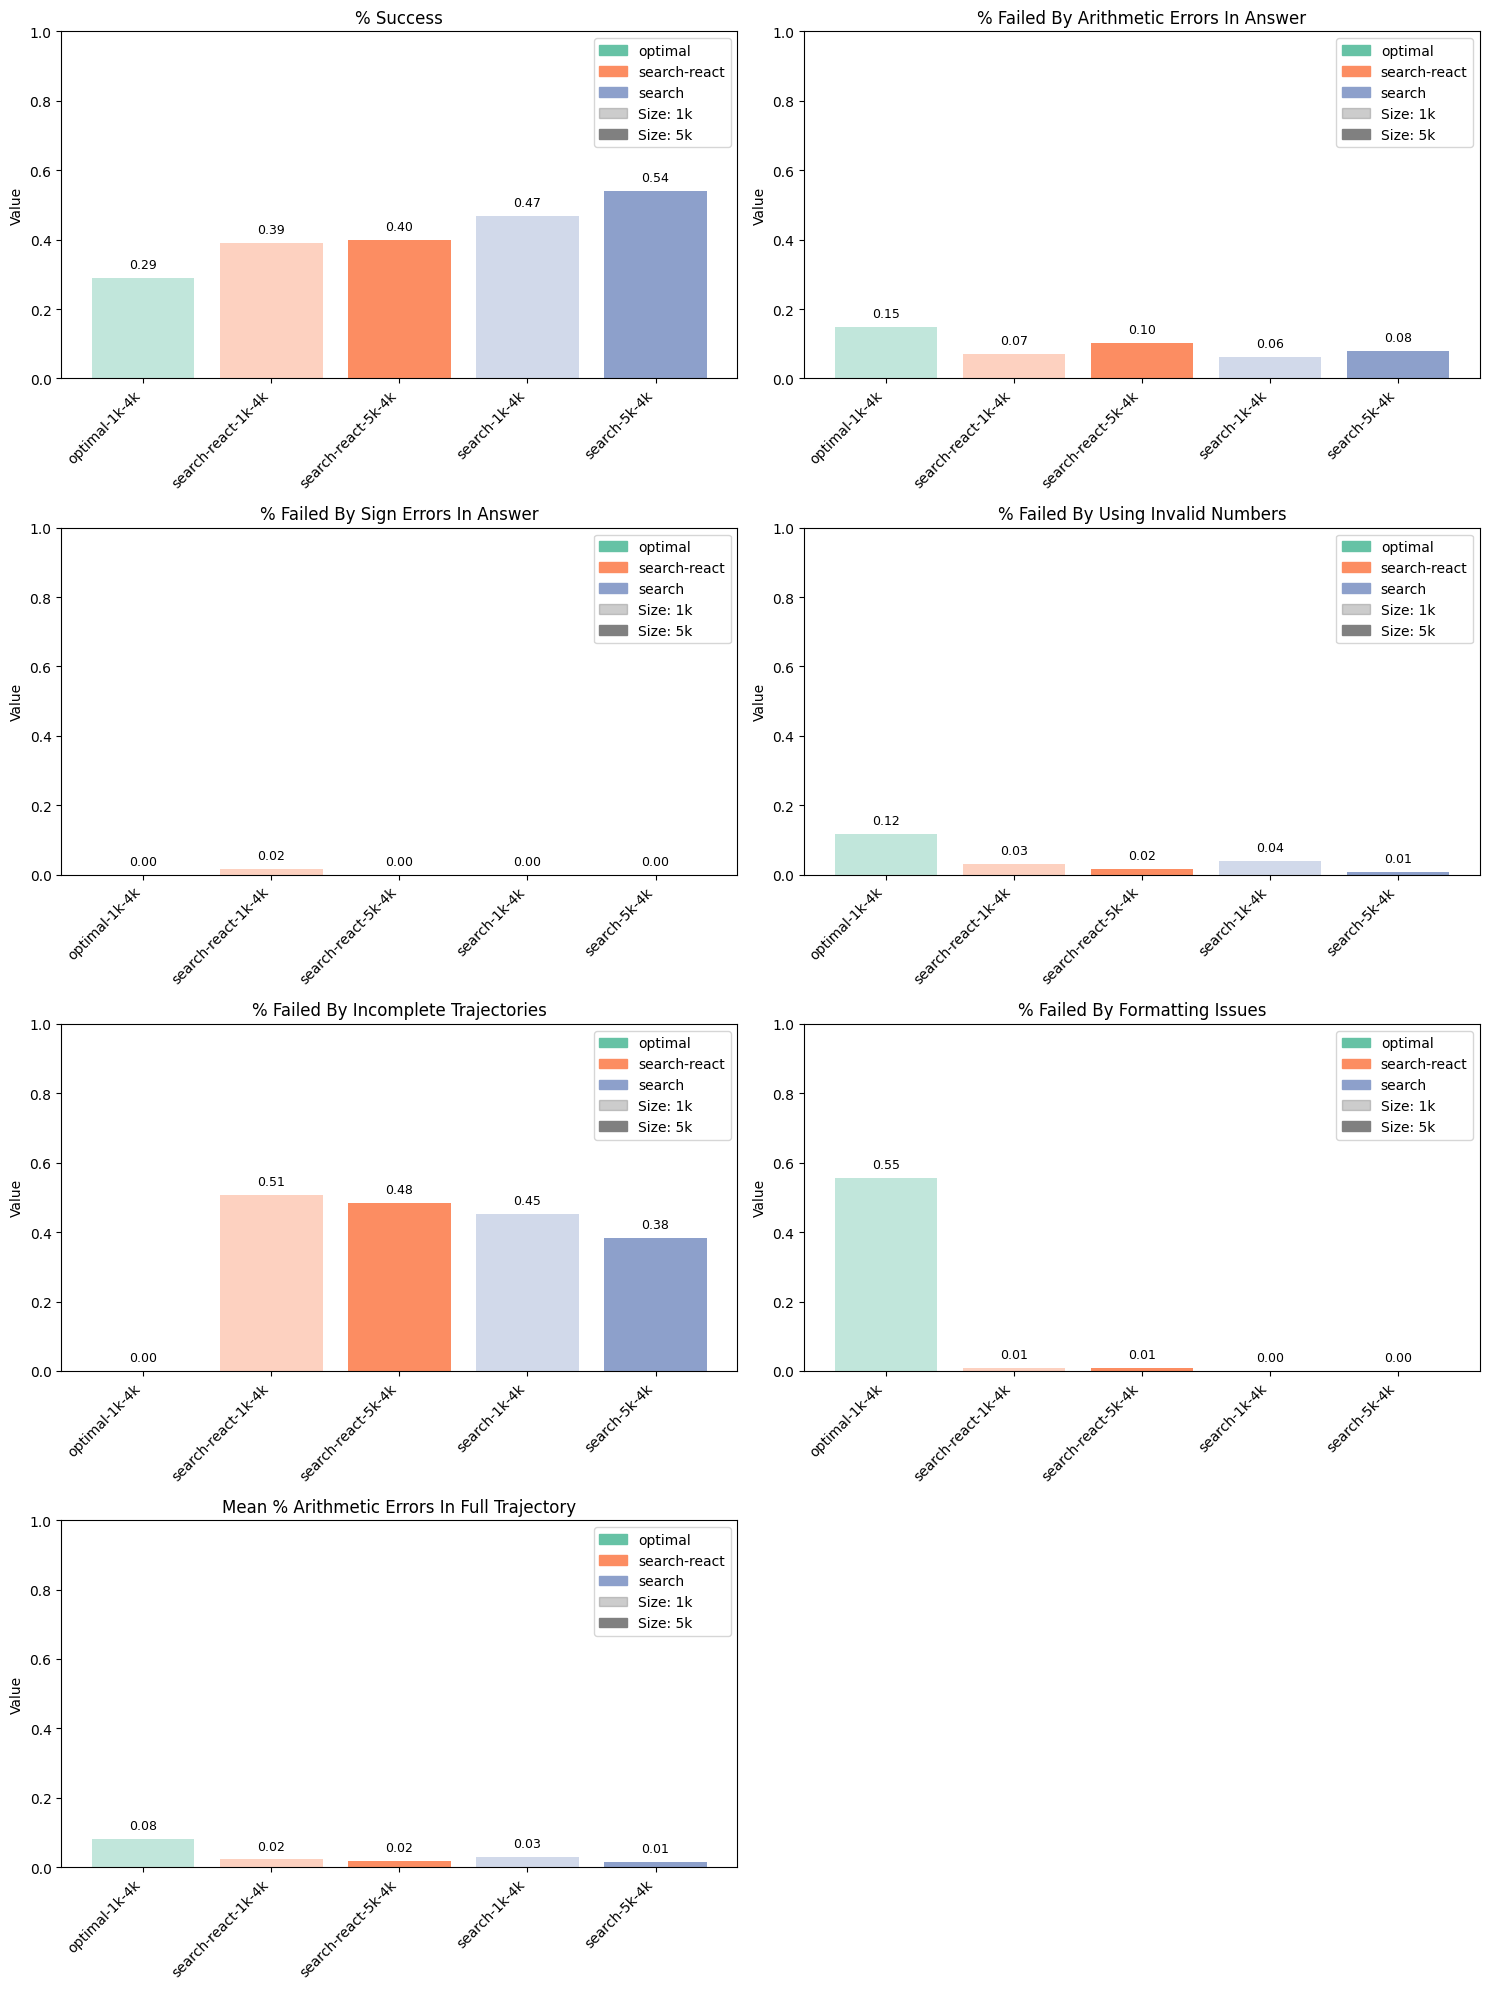

/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_20728/3492037685.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [ ]:
# Comparing multiple dataset sizes for 4k context length
fig = visualize_metrics(
    stats_df,
    dataset_types=['optimal', 'search-react', 'search'], 
    dataset_sizes=['1k','5k'],
    context_lengths=['4k']
)
fig.show()

Failure metrics to plot:
1. optimal
2. sos
3. sos-react-8k
4. sos-react-10k
4. sos-react-10k-rejection-sampled 
4. deepseek
5. deepseek-rejection-sampled

In [ ]:
def print_trajectories_by_failure_type_from_df(trajectories_df, file_path=None, failure_type=None, model_size=None, dataset_type=None, dataset_size=None, context_length=None, limit=5):
    """
    Print trajectories that match specified criteria using the pre-processed DataFrame.
    
    Args:
        trajectories_df (pd.DataFrame): DataFrame containing processed trajectories
        file_path (str, optional): Path to specific file to filter by
        failure_type (str, optional): Type of failure to filter by
        model_size (str, optional): Model size to filter by (e.g., "0.5B")
        dataset_type (str, optional): Dataset type to filter by (e.g., "search")
        limit (int, optional): Maximum number of trajectories to print
    """
    # Start with the full DataFrame
    filtered_df = trajectories_df.copy()
    
    # Apply filters
    if file_path:
        filtered_df = filtered_df[filtered_df["file_path"] == file_path]
    
    if model_size:
        filtered_df = filtered_df[filtered_df["model_size"] == model_size]
        
    if dataset_type:
        filtered_df = filtered_df[filtered_df["dataset_type"] == dataset_type]
        
    if dataset_size:
        filtered_df = filtered_df[filtered_df["dataset_size"] == dataset_size]
    
    if failure_type:
        if failure_type == "arithmetic_error":
            filtered_df = filtered_df[filtered_df["arithmetic_error"]]
        elif failure_type == "invalid_number":
            filtered_df = filtered_df[filtered_df["invalid_number_usage"]]
        elif failure_type == "formatting_issues":
            filtered_df = filtered_df[filtered_df["formatting_issues"]]
        elif failure_type == "incomplete":
            # Get max token count for each file
            file_max_tokens = filtered_df.groupby("file_path")["token_count"].max().to_dict()
            # Filter trajectories that hit max tokens and have formatting issues
            filtered_df = filtered_df[
                filtered_df.apply(
                    lambda row: row["formatting_issues"] and row["token_count"] == file_max_tokens[row["file_path"]], 
                    axis=1
                )
            ]
        elif failure_type == "valid":
            filtered_df = filtered_df[filtered_df["is_valid"]]
        else:
            print(f"Unknown failure type: {failure_type}")
            return
    
    # Print results
    print(f"Found {len(filtered_df)} trajectories matching criteria")
    
    for i, (_, traj) in enumerate(filtered_df.head(limit).iterrows()):
        print(f"\n--- Trajectory {traj['trajectory_index']} ---")
        print(f"Model: {traj['model_size']} {traj['dataset_type']} {traj['context_length']} {traj['dataset_size']}")
        print(f"Problem: {traj['nums']}")
        print(f"Target: {traj['target']}")
        print(f"Token count: {traj['token_count']}")
        
        if traj.get("arithmetic_error"):
            print(f"Arithmetic errors: {traj['arithmetic_error_count']} out of {traj['total_equations']} equations")
            print(f"Sign errors: {traj.get('sign_errors', 0)} out of {traj['arithmetic_error_count']} arithmetic errors")
        
        if traj.get("heuristic_calculation_count", 0) > 0:
            print(f"Heuristic calculations: {traj['heuristic_calculation_count']}")
            print(f"Heuristic calculation errors: {traj.get('heuristic_arithmetic_errors', 0)}")
        
        if traj.get("node_recall_errors", 0) > 0:
            print(f"Node recall errors: {traj['node_recall_errors']}")
        
        print("\nCompletion:")
        print(traj['completion'])
    
    if len(filtered_df) > limit:
        print(f"\n... {len(filtered_df) - limit} more trajectories not shown")

# Example usage:
# trajectory_df, stats_df = process_json_files("path/to/experiments")
# print_trajectories_by_failure_type_from_df(trajectory_df, failure_type="arithmetic_error", model_size="0.5B")

In [ ]:
print_trajectories_by_failure_type_from_df(trajectory_df, failure_type="arithmetic_error", model_size="1.5B", dataset_type="search-react", dataset_size="5k", limit=1)

Found 32 trajectories matching criteria

--- Trajectory 0 ---
Model: 1.5B search-react 10k 5k
Problem: [53, 57, 13, 48]
Target: 64
Token count: 12069
Arithmetic errors: 7 out of 174 equations
Sign errors: 0 out of 7 arithmetic errors
Heuristic calculations: 47
Heuristic calculation errors: 35

Completion:
system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.
user
Combine these initial numbers [53, 57, 13, 48] using only arithmetic operations (+, -, *, /) to reach the target value 64. All initial numbers must be used exactly once.
Conclude with the final result in EXACTLY this format:
```
SOLUTION: YES/NO
OPERATIONS: list of string of operations performed, each string involving only 1 operation. For example, ['A+B=C','C+D=E'] is allowed, ['A+B+D=E'] is not allowed
RESULT: final_value
```

assistant
We have these numbers [53, 57, 13, 48]. Our goal is to produce 64. Let's show the search process step by step:
One possible strategy is to use a Depth-First Search (DFS)

In [ ]:
print_trajectories_by_failure_type_from_df(trajectory_df, failure_type="arithmetic_error", model_size="1.5B", dataset_type="search", dataset_size="5k", limit=1)

Found 23 trajectories matching criteria

--- Trajectory 7 ---
Model: 1.5B search 8k 5k
Problem: [98, 68, 90, 47]
Target: 73
Token count: 3430
Arithmetic errors: 1 out of 108 equations
Sign errors: 0 out of 1 arithmetic errors

Completion:
system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.
user
Combine these initial numbers [98, 68, 90, 47] using only arithmetic operations (+, -, *, /) to reach the target value 73. All initial numbers must be used exactly once.
Conclude with the final result in EXACTLY this format:
```
SOLUTION: YES/NO
OPERATIONS: list of string of operations performed, each string involving only 1 operation. For example, ['A+B=C','C+D=E'] is allowed, ['A+B+D=E'] is not allowed
RESULT: final_value
```

assistant
Current State: 73:[98, 68, 90, 47], Operations: []
Exploring Operation: 98-47=51, Resulting Numbers: [68, 90, 51]
Generated Node #0,0: 73:[68, 90, 51] Operation: 98-47=51
Exploring Operation: 90-47=43, Resulting Numbers: [98, 68, 43]
Gen

In [ ]:
print_trajectories_by_failure_type_from_df(trajectory_df, failure_type="arithmetic_error", model_size="1.5B", dataset_type="search-react", limit=1)

Found 41 trajectories matching criteria

--- Trajectory 0 ---
Model: 1.5B search-react 10k 5k
Problem: [53, 57, 13, 48]
Target: 64
Token count: 12069
Arithmetic errors: 7 out of 174 equations
Sign errors: 0 out of 7 arithmetic errors
Heuristic calculations: 47
Heuristic calculation errors: 35

Completion:
system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.
user
Combine these initial numbers [53, 57, 13, 48] using only arithmetic operations (+, -, *, /) to reach the target value 64. All initial numbers must be used exactly once.
Conclude with the final result in EXACTLY this format:
```
SOLUTION: YES/NO
OPERATIONS: list of string of operations performed, each string involving only 1 operation. For example, ['A+B=C','C+D=E'] is allowed, ['A+B+D=E'] is not allowed
RESULT: final_value
```

assistant
We have these numbers [53, 57, 13, 48]. Our goal is to produce 64. Let's show the search process step by step:
One possible strategy is to use a Depth-First Search (DFS)

In [ ]:
print_trajectories_by_failure_type_from_df(trajectory_df, failure_type="incomplete", model_size="1.5B", dataset_type="search", dataset_size="5k", limit=1)

Found 51 trajectories matching criteria

--- Trajectory 0 ---
Model: 1.5B search 8k 5k
Problem: [53, 57, 13, 48]
Target: 64
Token count: 8333

Completion:
system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.
user
Combine these initial numbers [53, 57, 13, 48] using only arithmetic operations (+, -, *, /) to reach the target value 64. All initial numbers must be used exactly once.
Conclude with the final result in EXACTLY this format:
```
SOLUTION: YES/NO
OPERATIONS: list of string of operations performed, each string involving only 1 operation. For example, ['A+B=C','C+D=E'] is allowed, ['A+B+D=E'] is not allowed
RESULT: final_value
```

assistant
Current State: 64:[53, 57, 13, 48], Operations: []
Exploring Operation: 57-13=44, Resulting Numbers: [53, 48, 44]
Generated Node #0,0: 64:[53, 48, 44] Operation: 57-13=44
Exploring Operation: 53+48=101, Resulting Numbers: [13, 49, 101]
Generated Node #0,1: 64:[13, 49, 101] Operation: 53+48=101
Exploring Operation: 53+13